# Day 6: Model Evaluation & Metrics
## Week 4: Machine Learning Foundations

---

**Learning Objectives:**
- Master regression metrics (MSE, MAE, R², MAPE)
- Understand classification metrics deeply
- Learn trading-specific evaluation
- Implement backtesting metrics

In [1]:
# Day 6 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             precision_recall_curve, average_precision_score)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna() * 100

print("=" * 60)
print("MODEL EVALUATION & METRICS - DAY 6")
print("=" * 60)

MODEL EVALUATION & METRICS - DAY 6


## 1. Regression Metrics

In [2]:
# Create simple prediction setup
print("=" * 60)
print("REGRESSION METRICS")
print("=" * 60)

# Feature matrix
def create_features(returns, target_col):
    X = pd.DataFrame(index=returns.index)
    for lag in range(1, 6):
        X[f'lag_{lag}'] = returns[target_col].shift(lag)
    for col in returns.columns:
        if col != target_col:
            X[f'{col}_lag1'] = returns[col].shift(1)
    return X.dropna()

X = create_features(returns, 'SPY')
y = returns['SPY'].loc[X.index]

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit model
model = Ridge(alpha=1.0)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)

# Calculate metrics
print("\n📊 Regression Metrics:")
print(f"  MSE  (Mean Squared Error):     {mean_squared_error(y_test, y_pred):.6f}")
print(f"  RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
print(f"  MAE  (Mean Absolute Error):    {mean_absolute_error(y_test, y_pred):.6f}")
print(f"  R²   (Coefficient of Determination): {r2_score(y_test, y_pred):.6f}")

# Compare to naive benchmark
naive_pred = np.full_like(y_test, y_train.mean())  # Predict mean
print(f"\n📊 Naive Benchmark (predict mean):")
print(f"  MSE:  {mean_squared_error(y_test, naive_pred):.6f}")
print(f"  R²:   {r2_score(y_test, naive_pred):.6f}")

REGRESSION METRICS

📊 Regression Metrics:
  MSE  (Mean Squared Error):     1.217573
  RMSE (Root Mean Squared Error): 1.103437
  MAE  (Mean Absolute Error):    0.681321
  R²   (Coefficient of Determination): 0.008784

📊 Naive Benchmark (predict mean):
  MSE:  1.228369
  R²:   -0.000006


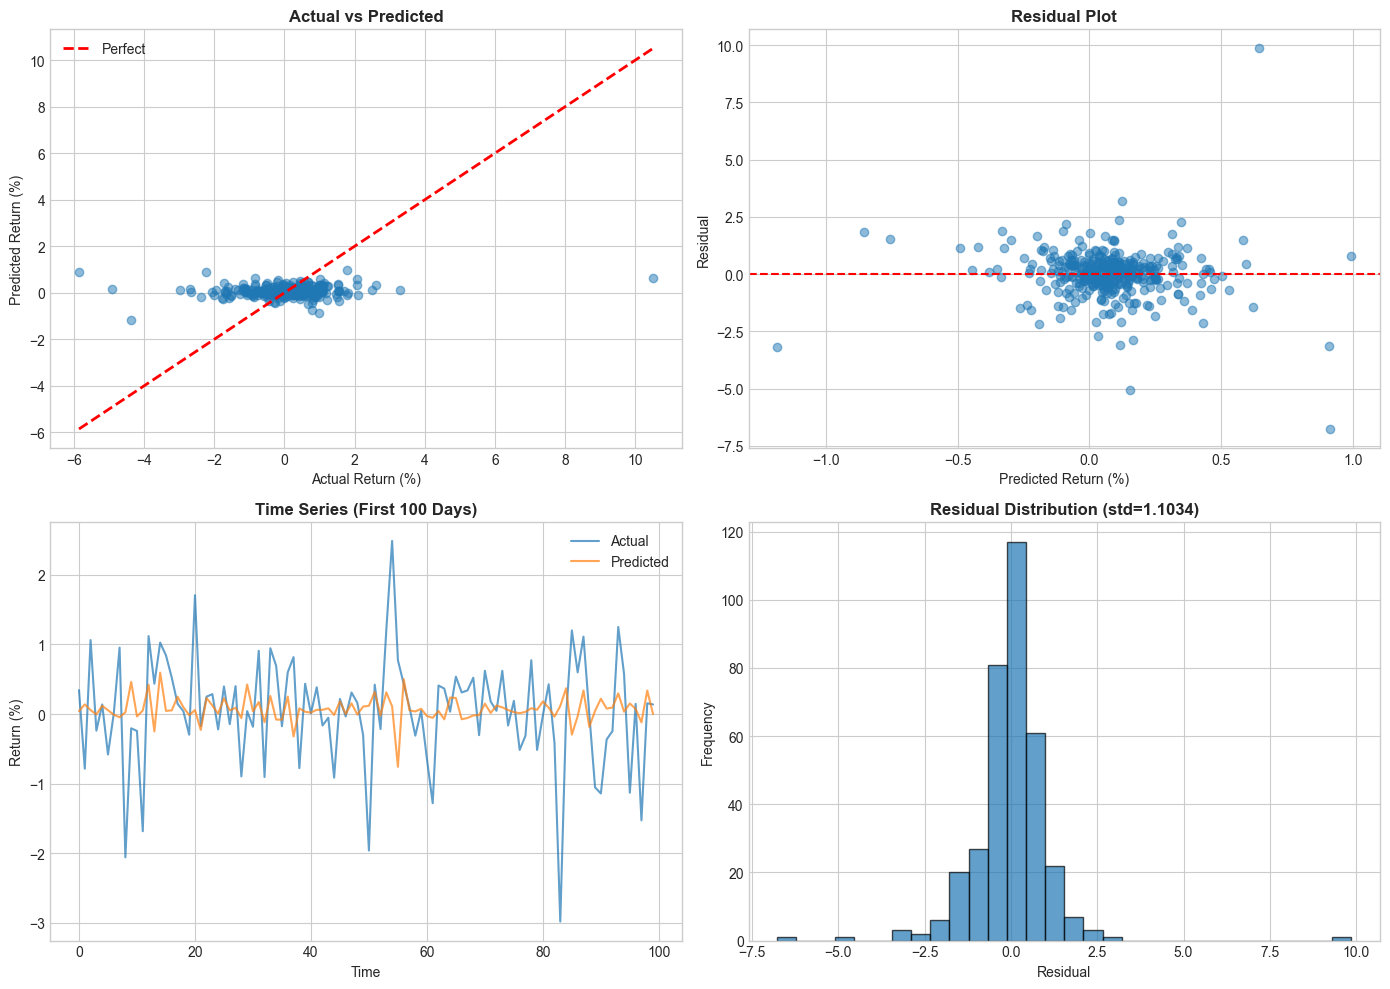

In [3]:
# Visualize regression predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.5)
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
axes[0, 0].set_xlabel('Actual Return (%)')
axes[0, 0].set_ylabel('Predicted Return (%)')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].legend()

# Residuals
residuals = y_test.values - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Return (%)')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].set_title('Residual Plot', fontweight='bold')

# Time series
axes[1, 0].plot(y_test.values[:100], label='Actual', alpha=0.7)
axes[1, 0].plot(y_pred[:100], label='Predicted', alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Return (%)')
axes[1, 0].set_title('Time Series (First 100 Days)', fontweight='bold')
axes[1, 0].legend()

# Residual distribution
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Residual Distribution (std={residuals.std():.4f})', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Classification Metrics Deep Dive

In [4]:
# Classification setup
print("=" * 60)
print("CLASSIFICATION METRICS DEEP DIVE")
print("=" * 60)

# Create binary target
y_binary = (returns['SPY'] > 0).astype(int).loc[X.index]

# Split
y_train_bin = y_binary.iloc[:split]
y_test_bin = y_binary.iloc[split:]

# Train classifier
clf = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
clf.fit(X_train_s, y_train_bin)
y_pred_bin = clf.predict(X_test_s)
y_prob = clf.predict_proba(X_test_s)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)
tn, fp, fn, tp = cm.ravel()

print("\n📊 Confusion Matrix:")
print(f"              Predicted")
print(f"              Down   Up")
print(f"  Actual Down  {tn:4d}  {fp:4d}")
print(f"  Actual Up    {fn:4d}  {tp:4d}")

print("\n📊 Derived Metrics:")
print(f"  Accuracy:     {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"  Precision:    {tp / (tp + fp):.4f}  (of predicted Up, how many correct?)")
print(f"  Recall:       {tp / (tp + fn):.4f}  (of actual Up, how many detected?)")
print(f"  Specificity:  {tn / (tn + fp):.4f}  (of actual Down, how many correct?)")
print(f"  F1 Score:     {2*tp / (2*tp + fp + fn):.4f}")
print(f"  AUC-ROC:      {roc_auc_score(y_test_bin, y_prob):.4f}")

CLASSIFICATION METRICS DEEP DIVE

📊 Confusion Matrix:
              Predicted
              Down   Up
  Actual Down     2   148
  Actual Up       7   196

📊 Derived Metrics:
  Accuracy:     0.5609
  Precision:    0.5698  (of predicted Up, how many correct?)
  Recall:       0.9655  (of actual Up, how many detected?)
  Specificity:  0.0133  (of actual Down, how many correct?)
  F1 Score:     0.7166
  AUC-ROC:      0.5295


PRECISION-RECALL ANALYSIS


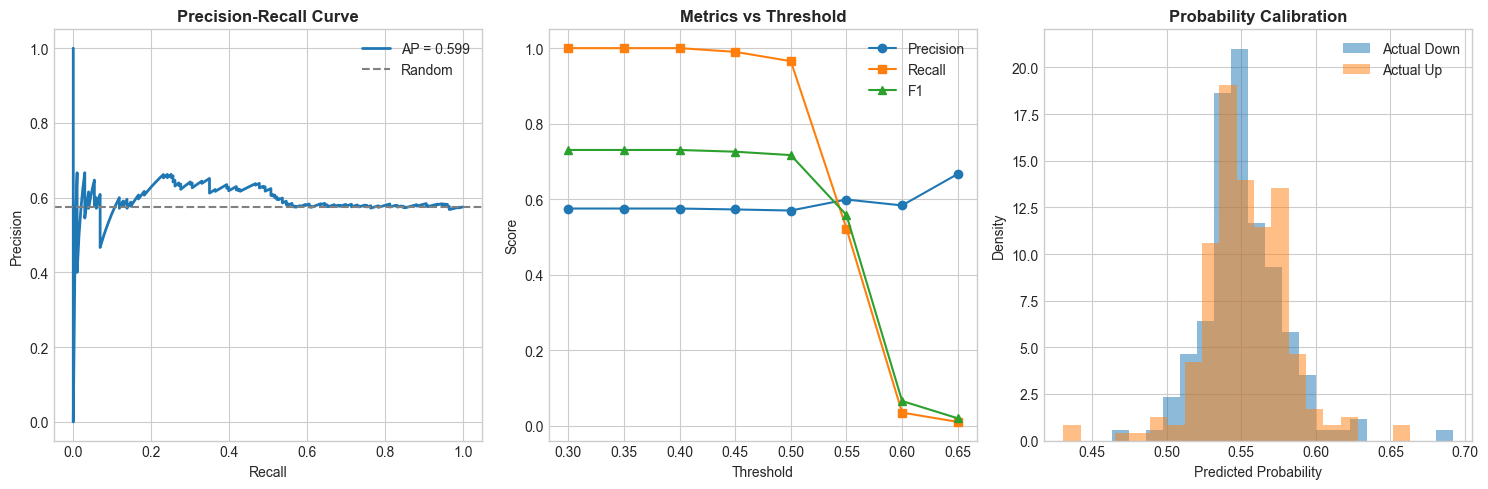


Threshold Analysis:
 Threshold  Precision   Recall       F1
      0.30   0.575071 1.000000 0.730216
      0.35   0.575071 1.000000 0.730216
      0.40   0.575071 1.000000 0.730216
      0.45   0.572650 0.990148 0.725632
      0.50   0.569767 0.965517 0.716636
      0.55   0.598870 0.522167 0.557895
      0.60   0.583333 0.034483 0.065116
      0.65   0.666667 0.009852 0.019417


In [5]:
# Precision-Recall analysis
print("=" * 60)
print("PRECISION-RECALL ANALYSIS")
print("=" * 60)

# Calculate curves
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test_bin, y_prob)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision-Recall curve
ap = average_precision_score(y_test_bin, y_prob)
axes[0].plot(recall_curve, precision_curve, lw=2, label=f'AP = {ap:.3f}')
axes[0].axhline(y=y_test_bin.mean(), color='gray', linestyle='--', label='Random')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve', fontweight='bold')
axes[0].legend()

# Threshold analysis
threshold_analysis = []
for t in np.arange(0.3, 0.7, 0.05):
    y_pred_t = (y_prob >= t).astype(int)
    threshold_analysis.append({
        'Threshold': t,
        'Precision': precision_score(y_test_bin, y_pred_t, zero_division=0),
        'Recall': recall_score(y_test_bin, y_pred_t, zero_division=0),
        'F1': f1_score(y_test_bin, y_pred_t, zero_division=0)
    })

t_df = pd.DataFrame(threshold_analysis)
axes[1].plot(t_df['Threshold'], t_df['Precision'], marker='o', label='Precision')
axes[1].plot(t_df['Threshold'], t_df['Recall'], marker='s', label='Recall')
axes[1].plot(t_df['Threshold'], t_df['F1'], marker='^', label='F1')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Metrics vs Threshold', fontweight='bold')
axes[1].legend()

# Probability histogram
axes[2].hist(y_prob[y_test_bin == 0], bins=20, alpha=0.5, label='Actual Down', density=True)
axes[2].hist(y_prob[y_test_bin == 1], bins=20, alpha=0.5, label='Actual Up', density=True)
axes[2].set_xlabel('Predicted Probability')
axes[2].set_ylabel('Density')
axes[2].set_title('Probability Calibration', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nThreshold Analysis:")
print(t_df.to_string(index=False))

## 3. Trading-Specific Metrics

In [6]:
# Trading-specific evaluation
print("=" * 60)
print("TRADING-SPECIFIC METRICS")
print("=" * 60)

def trading_metrics(y_true, y_pred, returns):
    """Calculate trading-specific metrics."""
    # Directional accuracy
    correct_direction = ((y_pred > 0) == (y_true > 0)).mean()
    
    # Hit rate (when predicting up, how often correct)
    up_predictions = y_pred > 0
    if up_predictions.sum() > 0:
        hit_rate = (returns[up_predictions] > 0).mean()
    else:
        hit_rate = 0
    
    # Average gain vs loss
    strategy_returns = np.where(y_pred > 0, returns, 0)
    wins = strategy_returns[strategy_returns > 0]
    losses = strategy_returns[strategy_returns < 0]
    
    avg_win = wins.mean() if len(wins) > 0 else 0
    avg_loss = abs(losses.mean()) if len(losses) > 0 else 0
    
    # Profit factor
    gross_profit = wins.sum() if len(wins) > 0 else 0
    gross_loss = abs(losses.sum()) if len(losses) > 0 else 1e-10
    profit_factor = gross_profit / gross_loss
    
    # Information coefficient (correlation)
    ic = np.corrcoef(y_pred.flatten(), returns)[0, 1]
    
    return {
        'Directional Accuracy': correct_direction,
        'Hit Rate': hit_rate,
        'Avg Win': avg_win,
        'Avg Loss': avg_loss,
        'Win/Loss Ratio': avg_win / avg_loss if avg_loss > 0 else np.inf,
        'Profit Factor': profit_factor,
        'Information Coefficient': ic
    }

# Calculate for our model
y_test_arr = y_test.values
metrics = trading_metrics(y_test_arr, y_pred, y_test_arr)

print("\n📊 Trading Metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

print("\n💡 Interpretation:")
print(f"  - Directional Accuracy > 50% is better than random")
print(f"  - IC > 0.05 is generally considered significant")
print(f"  - Profit Factor > 1.5 is a reasonable target")

TRADING-SPECIFIC METRICS

📊 Trading Metrics:
  Directional Accuracy: 0.5581
  Hit Rate: 0.5951
  Avg Win: 0.6755
  Avg Loss: 0.7270
  Win/Loss Ratio: 0.9292
  Profit Factor: 1.3659
  Information Coefficient: 0.1183

💡 Interpretation:
  - Directional Accuracy > 50% is better than random
  - IC > 0.05 is generally considered significant
  - Profit Factor > 1.5 is a reasonable target


In [8]:
# Backtest metrics
print("=" * 60)
print("BACKTEST METRICS")
print("=" * 60)

def backtest_metrics(strategy_returns, benchmark_returns, rf_rate=0.0):
    """Calculate comprehensive backtest metrics."""
    # Convert to pandas Series if numpy array
    if isinstance(strategy_returns, np.ndarray):
        strategy_returns = pd.Series(strategy_returns)
    if isinstance(benchmark_returns, np.ndarray):
        benchmark_returns = pd.Series(benchmark_returns)
    
    # Annualization factor
    ann = 252
    
    # Basic returns
    total_return = (1 + strategy_returns / 100).prod() - 1
    ann_return = (1 + total_return) ** (ann / len(strategy_returns)) - 1
    
    # Volatility
    daily_vol = (strategy_returns / 100).std()
    ann_vol = daily_vol * np.sqrt(ann)
    
    # Sharpe
    excess_return = ann_return - rf_rate
    sharpe = excess_return / ann_vol if ann_vol > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + strategy_returns / 100).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Beta and alpha
    if benchmark_returns is not None:
        cov = np.cov(strategy_returns / 100, benchmark_returns / 100)
        beta = cov[0, 1] / cov[1, 1] if cov[1, 1] > 0 else 0
        
        bm_return = (1 + benchmark_returns / 100).prod() ** (ann / len(benchmark_returns)) - 1
        alpha = ann_return - (rf_rate + beta * (bm_return - rf_rate))
    else:
        beta, alpha = 0, 0
    
    return {
        'Total Return': total_return,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Beta': beta,
        'Alpha': alpha
    }

# Strategy: Long when predict up
position = (y_pred > 0).astype(int)
strategy_ret = position * y_test.values

# Calculate metrics
bt_metrics = backtest_metrics(strategy_ret, y_test.values)

print("\n📊 Backtest Performance:")
for metric, value in bt_metrics.items():
    if 'Return' in metric or 'Volatility' in metric or 'Drawdown' in metric or 'Alpha' in metric:
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")

BACKTEST METRICS

📊 Backtest Performance:
  Total Return: 28.27%
  Annualized Return: 19.45%
  Annualized Volatility: 15.69%
  Sharpe Ratio: 1.2398
  Max Drawdown: -15.10%
  Calmar Ratio: 1.2877
  Beta: 0.7931
  Alpha: 5.19%


## 4. Out-of-Sample Testing

ROLLING OUT-OF-SAMPLE EVALUATION

Overall Out-of-Sample Metrics:
  MSE: 1.228966
  R²:  -0.055852
  IC:  -0.0174

Rolling IC Statistics:
  Mean IC:   -0.0010
  IC Std:    0.1711
  % IC > 0:  51.4%


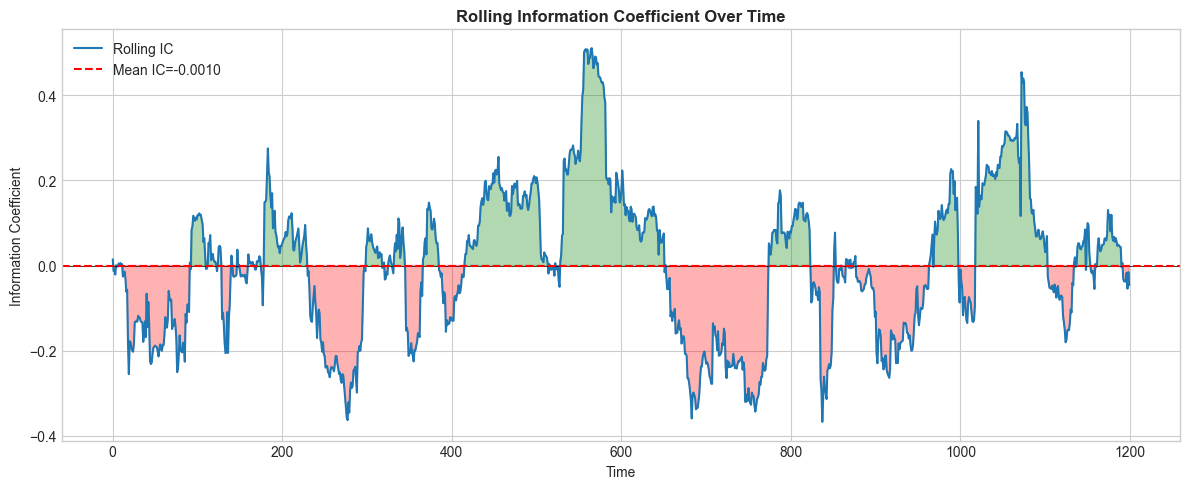

In [9]:
# Rolling out-of-sample test
print("=" * 60)
print("ROLLING OUT-OF-SAMPLE EVALUATION")
print("=" * 60)

def rolling_backtest(X, y, train_window=500, test_window=50):
    """Walk-forward backtest."""
    predictions = []
    actuals = []
    dates = []
    
    scaler = StandardScaler()
    model = Ridge(alpha=1.0)
    
    for i in range(train_window, len(X) - test_window, test_window):
        # Training data
        X_train = X.iloc[i-train_window:i]
        y_train = y.iloc[i-train_window:i]
        
        # Test data
        X_test = X.iloc[i:i+test_window]
        y_test_actual = y.iloc[i:i+test_window]
        
        # Scale and fit
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        model.fit(X_train_s, y_train)
        y_pred = model.predict(X_test_s)
        
        predictions.extend(y_pred)
        actuals.extend(y_test_actual.values)
        dates.extend(X_test.index)
    
    return np.array(predictions), np.array(actuals), dates

# Run rolling backtest
preds, acts, dates = rolling_backtest(X, y)

# Calculate metrics over time
window = 50
rolling_ic = pd.Series(
    [np.corrcoef(preds[max(0,i-window):i], acts[max(0,i-window):i])[0,1] 
     for i in range(window, len(preds))]
)

print(f"\nOverall Out-of-Sample Metrics:")
print(f"  MSE: {mean_squared_error(acts, preds):.6f}")
print(f"  R²:  {r2_score(acts, preds):.6f}")
print(f"  IC:  {np.corrcoef(preds, acts)[0,1]:.4f}")

print(f"\nRolling IC Statistics:")
print(f"  Mean IC:   {rolling_ic.mean():.4f}")
print(f"  IC Std:    {rolling_ic.std():.4f}")
print(f"  % IC > 0:  {(rolling_ic > 0).mean():.1%}")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rolling_ic.values, label='Rolling IC')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=rolling_ic.mean(), color='red', linestyle='--', label=f'Mean IC={rolling_ic.mean():.4f}')
ax.fill_between(range(len(rolling_ic)), rolling_ic, 0, 
                where=rolling_ic > 0, alpha=0.3, color='green')
ax.fill_between(range(len(rolling_ic)), rolling_ic, 0, 
                where=rolling_ic <= 0, alpha=0.3, color='red')
ax.set_xlabel('Time')
ax.set_ylabel('Information Coefficient')
ax.set_title('Rolling Information Coefficient Over Time', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 6

### Regression Metrics Summary:
| Metric | Formula | Use Case |
|--------|---------|----------|
| MSE | $\frac{1}{n}\sum(y-\hat{y})^2$ | Penalizes large errors |
| MAE | $\frac{1}{n}\sum|y-\hat{y}|$ | Robust to outliers |
| R² | $1 - \frac{SS_{res}}{SS_{tot}}$ | Variance explained |
| IC | $corr(\hat{y}, y)$ | Signal strength |

### Classification Metrics:
| Metric | Focus | Trading Use |
|--------|-------|-------------|
| Accuracy | Overall | Not useful alone |
| Precision | False positives | Avoid bad trades |
| Recall | Miss rate | Capture opportunities |
| AUC | Ranking | Model comparison |

### Trading-Specific:
- **Hit Rate**: % of trades profitable
- **Profit Factor**: Gross profit / Gross loss
- **Information Coefficient (IC)**: Correlation between prediction and actual
- **Sharpe Ratio**: Risk-adjusted return

### Interview Questions:
- "What's more important: precision or recall for a long-only strategy?"
- "How would you evaluate a model with high accuracy but low profitability?"
- "Explain the difference between R² and IC"